In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
# pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('..')

In [2]:
DATA = Path('data')
RAW  = DATA/'raw'
SUBMISSIONS = DATA/'submissions'

In [3]:
train      = pd.read_csv(RAW/'train_jqd04QH.csv', low_memory=False)
test       = pd.read_csv(RAW/'test_GYi4Gz5.csv', low_memory=False)
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)

In [4]:
id_col = 'enrollee_id'
cat_cols = ['city', 'gender', 'relevent_experience', 'enrolled_university', 
            'education_level', 'major_discipline', 'experience', 'company_size', 
            'company_type', 'last_new_job']
num_cols = ['city_development_index', 'training_hours']
target_col = 'target'

In [5]:
def get_dict(labels):
    return {label: idx for idx, label in enumerate(labels)}

In [6]:
labels = {
    'enrolled_university': get_dict(['no_enrollment', 'Part time course',
                                     'Full time course']),
    'education_level': get_dict(['Primary School', 'High School', 
                                 'Graduate', 'Masters', 'Phd']),
    'experience': get_dict(['<1'] + [str(x) for x in range(1,21)] + ['>20']),
    'company_size': get_dict(['<10', '10/49', '50-99', '100-500', '500-999', 
                              '1000-4999', '5000-9999', '10000+']),
    'last_new_job': get_dict([str(x) for x in range(1,5)] + ['>4', 'never'])
}

In [7]:
for col in labels:
    train[col] = train[col].map(labels[col])
    test[col] = test[col].map(labels[col])

In [8]:
from src.utils import to_cat_codes, apply_cats
to_cat_codes(train, [c for c in cat_cols if c not in labels])
apply_cats(test, train)
for col in cat_cols: 
    if col not in labels:
        train[col] = train[col].cat.codes
        test[col] = test[col].cat.codes

## Nan cols

In [9]:
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

In [10]:
nan_cols = [c for c in cat_cols if \
            any(df[c].min() < 0 for df in [train, test])]

In [11]:
for c in nan_cols:
    train[c] = train[c] + 1
    test[c] = test[c] + 1

## Num features

In [12]:
for col in labels:
    train[f'{col}_num'] = train[col]
    test[f'{col}_num'] = test[col]
    num_cols.append(f'{col}_num')

In [13]:
num_cols

['city_development_index',
 'training_hours',
 'enrolled_university_num',
 'education_level_num',
 'experience_num',
 'company_size_num',
 'last_new_job_num']

In [14]:
cat_cols

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(pd.concat([train[num_cols], 
                                         test[num_cols]]))

In [16]:
def scale_features(df, scaler, num_cols):
    scaled = scaler.transform(df[num_cols])
    for i, col in enumerate(num_cols):
        df[col] = scaled[:,i]

In [17]:
scale_features(train, scaler, num_cols)
scale_features(test, scaler, num_cols)

## Validation split

In [18]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [19]:
kfolds = StratifiedKFold(n_splits=5, random_state=42)
trn_idx, val_idx = next(kfolds.split(train, train[target_col]))

In [20]:
len(trn_idx), len(val_idx)

(14687, 3672)

In [21]:
X_trn, y_trn = train.drop([id_col, target_col], axis=1), train[target_col]

In [22]:
X_val, y_val = X_trn.iloc[val_idx], y_trn.iloc[val_idx]
X_trn, y_trn = X_trn.iloc[trn_idx], y_trn.iloc[trn_idx]

In [98]:
X_tst = test.drop(id_col, axis=1)

## Catboost

In [37]:
columns = list(train.drop([id_col, target_col], axis=1))
cat_indices = [i for i, col in enumerate(columns) if col in cat_cols]

In [53]:
%%time
model = CatBoostClassifier(iterations=100, od_pval=0.001, 
                           eval_metric='AUC', random_seed=42)
model.fit(X_trn, y_trn, cat_features=cat_indices, verbose=False)
y_pred = model.predict_proba(X_val)[:,1]
print(roc_auc_score(y_val, y_pred))

Learning rate set to 0.278847
0.6882557684407338
CPU times: user 17.6 s, sys: 2 s, total: 19.6 s
Wall time: 5.24 s


## Data Loader

In [23]:
import torch.utils.data
from torch.utils.data import DataLoader, Dataset

In [24]:
class StructuredDataset(Dataset):
    def __init__(self, cats, conts, targets=None):
        self.cats = cats.values.astype(np.int64)
        self.conts = conts.values.astype(np.float32)
        self.targets = np.array(targets).astype(np.float32) \
                          if targets is not None else \
                          np.zeros(len(cats)).astype(np.float32)
    
    def __len__(self):
        return len(self.cats)
    
    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.targets[idx]]

In [26]:
cat_szs = [int(train[col].max() + 1) for col in cat_cols]
emb_szs = [(c, min(50, (c+1)//2)) for c in cat_szs]

In [27]:
{c: emb_sz for c, emb_sz in zip(cat_cols, emb_szs)}

{'city': (123, 50),
 'gender': (4, 2),
 'relevent_experience': (2, 1),
 'enrolled_university': (4, 2),
 'education_level': (6, 3),
 'major_discipline': (7, 4),
 'experience': (23, 12),
 'company_size': (9, 5),
 'company_type': (7, 4),
 'last_new_job': (7, 4)}

## Model

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [32]:
class StructuredNet(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, szs, drops):
        super().__init__()
        self.embs = nn.ModuleList([
            nn.Embedding(c, s) for c,s in emb_szs
        ])
        for emb in self.embs:
            self.emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont = n_emb, n_cont
        szs = [n_emb + n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)
        ])
        for o in self.lins:
            nn.init.kaiming_normal_(o.weight.data)
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]
        ])
        self.outp = nn.Linear(szs[-1], 1)
        nn.init.kaiming_normal_(self.outp.weight.data)
        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([
            nn.Dropout(drop) for drop in drops
        ])
        self.bn = nn.BatchNorm1d(n_cont)
        
    def forward(self, x_cat, x_cont):
        x = [emb(x_cat[:,i]) for i,emb in enumerate(self.embs)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)
        x2 = self.bn(x_cont)
        x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for lin, drop, bn in zip(self.lins, self.drops, self.bns):
            x = F.relu(lin(x))
            x = bn(x)
            x = drop(x)
        return self.outp(x)
    
    def emb_init(self, x):
        x = x.weight.data
        sc = 2 / (x.size(1) + 1)
        x.uniform_(-sc, sc)

In [97]:
def train_step(model, cats, conts, targets, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    preds = model(cats, conts)
    loss = criterion(preds.view(-1), targets)
    loss.backward()
    optimizer.step()
    return loss.item()

def get_predictions(model, data_loader, print_every=800, USE_CUDA=False):
    targets, preds = [], []
    model.eval()
    for batch_idx, (cats, conts, target) in enumerate(data_loader):
        with torch.no_grad():
            if USE_CUDA:
                cats, conts, target = cats.cuda(), conts.cuda(), target.cuda()
            pred = model(cats, conts)
            targets.extend(target.cpu())
            preds.extend(pred.cpu())
            assert len(targets) == len(preds)
            if batch_idx > 0 and batch_idx % print_every == 0:
                print('[{}/{} ({:.0f}%)]'.format(
                        batch_idx * len(cats), len(data_loader.dataset),
                        100. * batch_idx / len(data_loader)))
    return [x.item() for x in targets], [F.sigmoid(x).item() for x in preds]

def get_metrics(model, data_loader, USE_CUDA=False):
    targets, preds = get_predictions(model, data_loader, USE_CUDA=USE_CUDA)
    loss = nn.BCELoss()(torch.Tensor(preds), torch.Tensor(targets)).item()
    auc = roc_auc_score(targets, preds)
    return loss, auc

def train_model(model, train_loader, val_loader, optimizer, criterion,
                n_epochs, print_every=200, val_every=5, USE_CUDA=False):
    if USE_CUDA:
        model = model.cuda()
    train_losses = []
    val_losses = []
    val_auc_scores = []
    val_every *= print_every
    for epoch in range(n_epochs):
        train_loss = 0
        for batch_idx, (cats, conts, target) in enumerate(train_loader):
            if USE_CUDA:
                cats, conts, target = cats.cuda(), conts.cuda(), target.cuda()
            train_loss += train_step(model, cats, conts, target, optimizer, criterion)
            
            if batch_idx > 0 and batch_idx % print_every == 0:
                train_loss /= print_every
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch + 1, batch_idx * len(cats), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), train_loss))
                train_losses.append(train_loss)
                train_loss = 0
            
            if val_loader is not None and batch_idx > 0 and batch_idx % val_every == 0:
                val_loss, val_auc = get_metrics(model, val_loader, USE_CUDA)
                val_losses.append(val_loss)
                val_auc_scores.append(val_auc)
                print(f'ROC AUC Score: {val_auc:.6f}') 
                print(f'Validation Loss: {val_loss:.6f}')
        
        if val_loader is not None:
            print('Epoch Results:')
            train_loss, train_auc = get_metrics(model, train_loader, USE_CUDA)
            print(f'Train ROC AUC Score: {train_auc:.6f}')
            print(f'Train Loss: {train_loss:.6f}')
            val_loss, val_auc = get_metrics(model, val_loader, USE_CUDA)
            print(f'Validation ROC AUC Score: {val_auc:.6f}')
            print(f'Validation Loss: {val_loss:.6f}')       
        
        print()
    return model, train_losses, val_losses, val_auc_scores   

In [25]:
train_dl = DataLoader(StructuredDataset(
                X_trn[cat_cols], X_trn[num_cols], y_trn),
                batch_size=128, shuffle=True)
val_dl = DataLoader(StructuredDataset(
                X_val[cat_cols], X_val[num_cols], y_val),
                batch_size=128)

In [31]:
USE_CUDA = False

In [47]:
model = StructuredNet(emb_szs, n_cont=len(num_cols), emb_drop=0.2,
                      szs=[1000,500], drops=[0.5, 0.5])
if USE_CUDA: model = model.cuda()

In [48]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [49]:
%%time
model, train_losses, _, _ = train_model(
                model, train_dl, val_dl, optimizer, criterion,
                n_epochs=10, USE_CUDA=USE_CUDA, print_every=20, val_every=50)

Train Epoch: 1 [2560/14687 (17%)]	Loss: 0.769820
Train Epoch: 1 [5120/14687 (35%)]	Loss: 0.567141
Train Epoch: 1 [7680/14687 (52%)]	Loss: 0.453545
Train Epoch: 1 [10240/14687 (70%)]	Loss: 0.429784
Train Epoch: 1 [12800/14687 (87%)]	Loss: 0.418322
Epoch Results:
Train ROC AUC Score: 0.641542
Train Loss: 0.379175
Validation ROC AUC Score: 0.636126
Validation Loss: 0.380538

Train Epoch: 2 [2560/14687 (17%)]	Loss: 0.421585
Train Epoch: 2 [5120/14687 (35%)]	Loss: 0.392481
Train Epoch: 2 [7680/14687 (52%)]	Loss: 0.425082
Train Epoch: 2 [10240/14687 (70%)]	Loss: 0.421085
Train Epoch: 2 [12800/14687 (87%)]	Loss: 0.401994
Epoch Results:
Train ROC AUC Score: 0.684082
Train Loss: 0.366504
Validation ROC AUC Score: 0.663089
Validation Loss: 0.371328

Train Epoch: 3 [2560/14687 (17%)]	Loss: 0.403434
Train Epoch: 3 [5120/14687 (35%)]	Loss: 0.400877
Train Epoch: 3 [7680/14687 (52%)]	Loss: 0.384423
Train Epoch: 3 [10240/14687 (70%)]	Loss: 0.397448
Train Epoch: 3 [12800/14687 (87%)]	Loss: 0.378183
Epo

## Batch size 32

In [50]:
train_dl = DataLoader(StructuredDataset(
                X_trn[cat_cols], X_trn[num_cols], y_trn),
                batch_size=32, shuffle=True)
val_dl = DataLoader(StructuredDataset(
                X_val[cat_cols], X_val[num_cols], y_val),
                batch_size=32)

In [51]:
model = StructuredNet(emb_szs, n_cont=len(num_cols), emb_drop=0.2,
                      szs=[1000,500], drops=[0.5, 0.5])
if USE_CUDA: model = model.cuda()

In [52]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [54]:
%%time
model, train_losses, _, _ = train_model(
                model, train_dl, val_dl, optimizer, criterion,
                n_epochs=10, USE_CUDA=USE_CUDA, print_every=100, val_every=100)

Train Epoch: 1 [3200/14687 (22%)]	Loss: 0.563126
Train Epoch: 1 [6400/14687 (44%)]	Loss: 0.417935
Train Epoch: 1 [9600/14687 (65%)]	Loss: 0.416047
Train Epoch: 1 [12800/14687 (87%)]	Loss: 0.414606
Epoch Results:
Train ROC AUC Score: 0.676585
Train Loss: 0.370237
Validation ROC AUC Score: 0.665242
Validation Loss: 0.374183

Train Epoch: 2 [3200/14687 (22%)]	Loss: 0.408538
Train Epoch: 2 [6400/14687 (44%)]	Loss: 0.396013
Train Epoch: 2 [9600/14687 (65%)]	Loss: 0.406715
Train Epoch: 2 [12800/14687 (87%)]	Loss: 0.375009
Epoch Results:
Train ROC AUC Score: 0.686722
Train Loss: 0.365897
Validation ROC AUC Score: 0.674087
Validation Loss: 0.369452

Train Epoch: 3 [3200/14687 (22%)]	Loss: 0.390605
Train Epoch: 3 [6400/14687 (44%)]	Loss: 0.370729
Train Epoch: 3 [9600/14687 (65%)]	Loss: 0.387134
Train Epoch: 3 [12800/14687 (87%)]	Loss: 0.380467
Epoch Results:
Train ROC AUC Score: 0.690811
Train Loss: 0.362992
Validation ROC AUC Score: 0.671589
Validation Loss: 0.369429

Train Epoch: 4 [3200/1468

## Learning rate 3e-4

In [84]:
train_dl = DataLoader(StructuredDataset(
                X_trn[cat_cols], X_trn[num_cols], y_trn),
                batch_size=32, shuffle=True)
val_dl = DataLoader(StructuredDataset(
                X_val[cat_cols], X_val[num_cols], y_val),
                batch_size=32)

In [85]:
model = StructuredNet(emb_szs, n_cont=len(num_cols), emb_drop=0.2,
                      szs=[1000,500], drops=[0.5, 0.5])
if USE_CUDA: model = model.cuda()

In [86]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

In [87]:
%%time
model, train_losses, _, _ = train_model(
                model, train_dl, val_dl, optimizer, criterion,
                n_epochs=10, USE_CUDA=USE_CUDA, print_every=100, val_every=100)

Train Epoch: 1 [3200/14687 (22%)]	Loss: 0.705304
Train Epoch: 1 [6400/14687 (44%)]	Loss: 0.529094
Train Epoch: 1 [9600/14687 (65%)]	Loss: 0.452925
Train Epoch: 1 [12800/14687 (87%)]	Loss: 0.432174
Epoch Results:
Train ROC AUC Score: 0.650599
Train Loss: 0.374380
Validation ROC AUC Score: 0.651533
Validation Loss: 0.376317

Train Epoch: 2 [3200/14687 (22%)]	Loss: 0.414990
Train Epoch: 2 [6400/14687 (44%)]	Loss: 0.421798
Train Epoch: 2 [9600/14687 (65%)]	Loss: 0.423826
Train Epoch: 2 [12800/14687 (87%)]	Loss: 0.399123
Epoch Results:
Train ROC AUC Score: 0.672821
Train Loss: 0.367936
Validation ROC AUC Score: 0.667576
Validation Loss: 0.371802

Train Epoch: 3 [3200/14687 (22%)]	Loss: 0.412871
Train Epoch: 3 [6400/14687 (44%)]	Loss: 0.380013
Train Epoch: 3 [9600/14687 (65%)]	Loss: 0.393561
Train Epoch: 3 [12800/14687 (87%)]	Loss: 0.422892
Epoch Results:
Train ROC AUC Score: 0.685604
Train Loss: 0.364399
Validation ROC AUC Score: 0.678003
Validation Loss: 0.368196

Train Epoch: 4 [3200/1468

## All datasets

In [100]:
train_ds = StructuredDataset(X_trn[cat_cols], X_trn[num_cols], y_trn)
val_ds   = StructuredDataset(X_val[cat_cols], X_val[num_cols], y_val)
test_ds  = StructuredDataset(X_tst[cat_cols], X_tst[num_cols], None)

In [101]:
from torch.utils.data import ConcatDataset

In [102]:
all_train_ds = ConcatDataset([train_ds, val_ds])

In [103]:
all_train_dl = DataLoader(all_train_ds, batch_size=32, shuffle=True)
test_dl      = DataLoader(test_ds, batch_size=32)

In [107]:
model = StructuredNet(emb_szs, n_cont=len(num_cols), emb_drop=0.2,
                      szs=[1000,500], drops=[0.5, 0.5])
if USE_CUDA: model = model.cuda()

In [108]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

In [109]:
%%time
model, train_losses, _, _ = train_model(
                model, all_train_dl, None, optimizer, criterion,
                n_epochs=7, USE_CUDA=USE_CUDA, print_every=100, val_every=100)

Train Epoch: 1 [3200/18359 (17%)]	Loss: 0.698612
Train Epoch: 1 [6400/18359 (35%)]	Loss: 0.537840
Train Epoch: 1 [9600/18359 (52%)]	Loss: 0.449713
Train Epoch: 1 [12800/18359 (70%)]	Loss: 0.424793
Train Epoch: 1 [16000/18359 (87%)]	Loss: 0.424301

Train Epoch: 2 [3200/18359 (17%)]	Loss: 0.430523
Train Epoch: 2 [6400/18359 (35%)]	Loss: 0.389235
Train Epoch: 2 [9600/18359 (52%)]	Loss: 0.422659
Train Epoch: 2 [12800/18359 (70%)]	Loss: 0.401373
Train Epoch: 2 [16000/18359 (87%)]	Loss: 0.398717

Train Epoch: 3 [3200/18359 (17%)]	Loss: 0.407043
Train Epoch: 3 [6400/18359 (35%)]	Loss: 0.399549
Train Epoch: 3 [9600/18359 (52%)]	Loss: 0.372939
Train Epoch: 3 [12800/18359 (70%)]	Loss: 0.394654
Train Epoch: 3 [16000/18359 (87%)]	Loss: 0.405772

Train Epoch: 4 [3200/18359 (17%)]	Loss: 0.365628
Train Epoch: 4 [6400/18359 (35%)]	Loss: 0.403122
Train Epoch: 4 [9600/18359 (52%)]	Loss: 0.390472
Train Epoch: 4 [12800/18359 (70%)]	Loss: 0.380876
Train Epoch: 4 [16000/18359 (87%)]	Loss: 0.411743

Train Ep

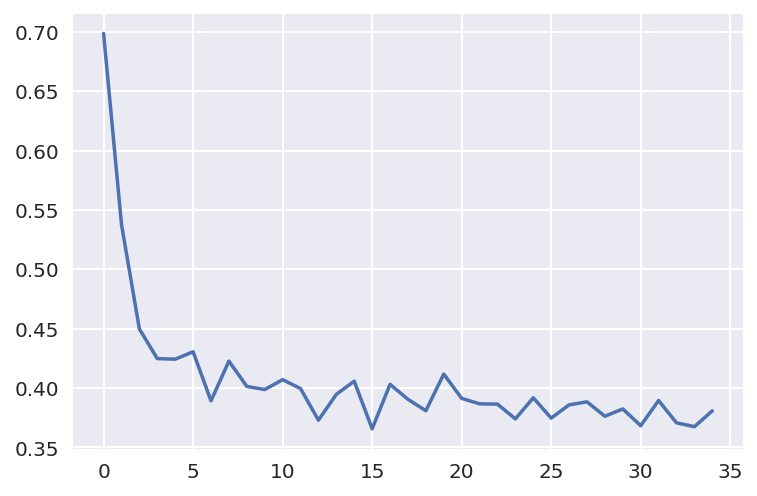

In [110]:
train_losses = pd.Series(train_losses)
train_losses.plot()

In [111]:
targets, preds = get_predictions(model, test_dl, USE_CUDA=USE_CUDA)

In [112]:
test[target_col] = preds

## Submission

In [113]:
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)

In [114]:
submission.head()

,enrollee_id,target
0,16548,0.367501
1,12036,0.055319
2,11061,0.335810
3,5032,0.058766
4,17599,0.074805


In [115]:
submission[target_col].describe()

count    15021.000000
mean         0.120405
std          0.073333
min          0.014991
25%          0.068073
50%          0.095120
75%          0.151700
max          0.512630
Name: target, dtype: float64

In [116]:
submission.to_csv(SUBMISSIONS/'07-neuralnet_labelordinal_alldata.csv', index=False)

## Average with catboost

In [119]:
catboost_sub = pd.read_csv(SUBMISSIONS/'06-catboost_labelordinal_alldata.csv')

In [120]:
catboost_sub.head()

,enrollee_id,target
0,16548,0.558407
1,12036,0.063185
2,11061,0.471543
3,5032,0.083252
4,17599,0.148626


In [126]:
catboost_sub[target_col].describe()

count    15021.000000
mean         0.132935
std          0.084021
min          0.029717
25%          0.074395
50%          0.102081
75%          0.163948
max          0.683786
Name: target, dtype: float64

In [121]:
average_sub = catboost_sub.copy()

In [122]:
average_sub[target_col] = (catboost_sub[target_col] + submission[target_col]) / 2

In [123]:
average_sub.head()

,enrollee_id,target
0,16548,0.462954
1,12036,0.059252
2,11061,0.403677
3,5032,0.071009
4,17599,0.111716


In [125]:
average_sub[target_col].describe()

count    15021.000000
mean         0.126670
std          0.076417
min          0.031154
25%          0.072441
50%          0.099154
75%          0.157438
max          0.540061
Name: target, dtype: float64

In [128]:
average_sub.to_csv(SUBMISSIONS/'08-ensemble_neuralnet_catboost_labelordinal_alldata.csv', index=False)